## 1. Load the training set and validation set.

In [9]:
%matplotlib inline
from sklearn.externals.joblib import Memory 
from sklearn.datasets import load_svmlight_file 
import numpy as np

def load_data(add,n=None):
    data = load_svmlight_file(add,n)
    return data[0],data[1]

data_train = "C:\\Users\\Administrator\\Desktop\\机器学习\\lab2\\a9a.txt"
data_valid = "C:\\Users\\Administrator\\Desktop\\机器学习\\lab2\\a9a_t.txt"

x_train,y_train = load_data(data_train,123)
x_valid,y_valid = load_data(data_valid,123)

x_train = x_train.todense()
x_valid = x_valid.todense()
#Step1::Load the training set and validation set

y_train = (y_train+1)/2
y_valid = (y_valid+1)/2
#Transform label y  from (-1,1) into (0,1)

## 2.Initalize logistic regression model parameters randomly.

In [10]:
w = 2*(np.random.random([x_train.shape[1]+1,1]))-1
#Step2:Initalize logistic regression model parameters randomly.
w_temp = w #Store the random w

## 4.Select the loss function and calculate its derivation.

In [11]:
#Step3:Select the loss function and calculate its derivation.

$$ J（W） = -\frac{1}{n}\left\lgroup\sum_{i=1}^ny_i\log h_w(x_i)+(1-y_i)\log(1-h_w(x_i))\right\rgroup  $$

$$ \frac{\partial J（W）}{\partial W}=\frac{1}{n}\sum_{i=1}^n(h_w(x_i)-y)x_i     $$

## 5.Logistic Regression and Stochastic Gradient Descent.

0.7909219335421657
0.8468767274737424
0.8455868804127511
0.8458325655672256
0.8366807935630489


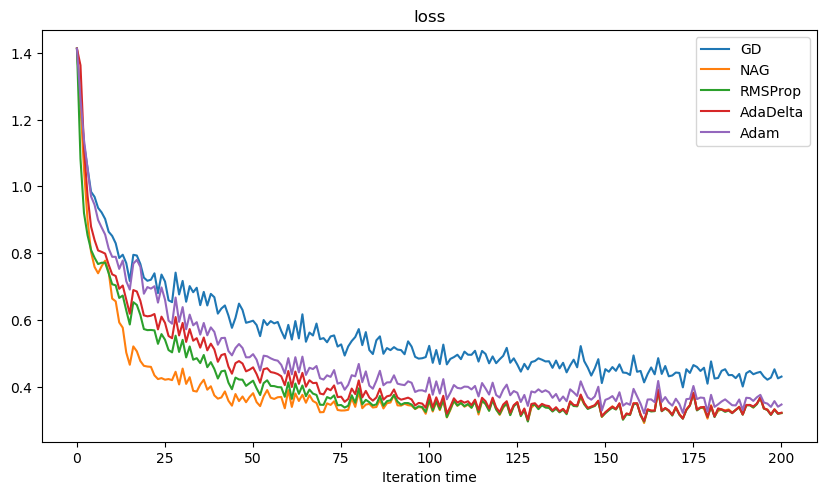

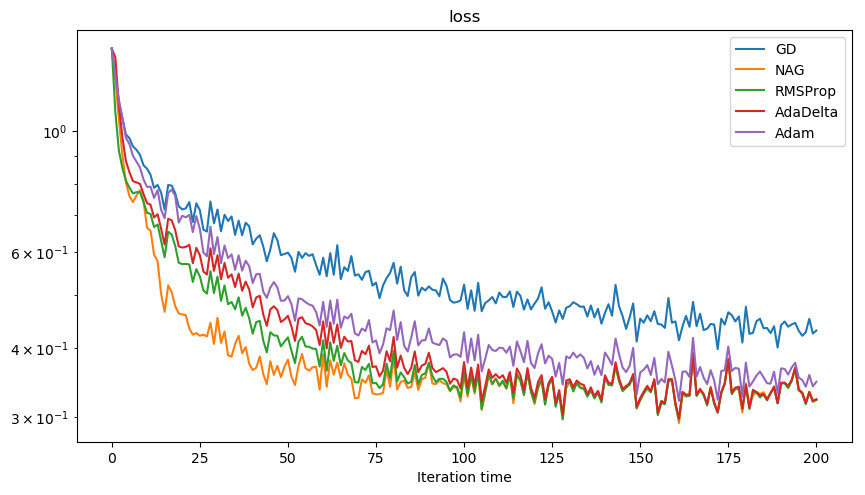

In [12]:
import matplotlib.pyplot as plt
from scipy import sparse

def getRandomBatch(num_batch,x,y):#Create random batch from data set
    n_r = np.random.randint(x.shape[0])
    x_batch = x[n_r]
    y_batch = []
    y_batch.append(y[n_r])
    for n in range(num_batch-1):
            n_r = np.random.randint(x.shape[0])
            x_batch = np.concatenate((x_batch, x[n_r]), axis=0)
            y_batch.append(y[n_r])
    
    y_batch = np.array(y_batch)
    y_batch.shape = (num_batch,1)
    return x_batch,y_batch

def h_w(w,x): # H function
    h = 1/(1+np.exp(-x.dot(w)))
    return h

def get_loss(x,y,w): #Loss of data set
    h = h_w(w,x)
    loss = -1/x.shape[0] * ( y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h)))
    return loss[0,0]

def get_gradient(x,y,w):#Calculate Gradient
    G = 1/x.shape[0] * ( x.T.dot((h_w(w,x)-y)) )
    return G

def get_gradient_NAG(x,y,w,v,decay_rate=0.9): #Calculate Gradient
    w = w + decay_rate*v
    G = 1/x.shape[0] * ( x.T.dot((h_w(w,x)-y)) )
    return G

def update_w_GD(w,G,learn_rate): #Update w,b parameters
    w = w - learn_rate*G
    return w

def update_w_NAG(w,v,G,learn_rate=0.5,v_rate=0.9): #Update w parameters
    
    v = v_rate*v - learn_rate*G
    w = w + v
    return w,v

def update_w_RMSProp(w,r,G,learn_rate=0.5,decay_rate=0.9,mini_number=0.00000001):#Update w parameters
    r = decay_rate*r + (1-decay_rate)*G.T.dot(G)
    w = w - learn_rate*G/np.sqrt(mini_number + r)
    return w,r

def update_w_AdaDelta(w,E_g,E_w,G,learn_rate=0.5,decay_rate=0.9,mini_number=0.00000001):#Update w parameters
    E_g = decay_rate*E_g + (1-decay_rate)*G.T.dot(G)[0,0]
    w = w - np.sqrt(mini_number + E_w)/np.sqrt(mini_number + E_g)*G
    E_w = decay_rate*E_w + (1-decay_rate)*( (learn_rate*G/np.sqrt(mini_number + E_g)).T.dot(learn_rate*G/np.sqrt(mini_number + E_g))[0,0] )
    return w,E_g,E_w

def update_w_Adam(w,s,r,t,G,learn_rate=0.5,decay_rate1=0.9,decay_rate2 = 0.999,mini_number=0.00000001):#Update w parameters
    s = decay_rate1*s + (1-decay_rate1)*G
    r = decay_rate2*r + (1-decay_rate2)*G.T.dot(G)
    s_b = s/(1-np.power(decay_rate1,t))
    r_b = r/(1-np.power(decay_rate2,t))
    w = w - learn_rate*s_b/(np.sqrt(r_b)+mini_number)
    return w,s,r

def predict_result(x,w,threshold):# Predict y with w and data set
    y_predict = []
    h = h_w(w,x)
    for a in range(x.shape[0]):
        if(h[a]>=threshold):
            y_predict.append(1)
        else:
            y_predict.append(0)
    return y_predict

def get_accuracy(y_predict,y_valid):#Calculate the accuracy
    accuracy = 0
    for a in range(y_valid.shape[0]):
        if(y_predict[a]==y_valid[a]):
            accuracy+=1     
    return accuracy/y_valid.shape[0]

m_train = x_train.shape[0] #number of training example
m_valid = x_valid.shape[0] #number of validation example

x_1_train = np.ones((m_train,1),dtype='float64') #creat [1,1,……,1]^T
X_train = np.concatenate((x_train,x_1_train),axis=1) #merge x_train and [1,1,……,1]^T

x_1_valid = np.ones((m_valid,1),dtype='float64') #creat [1,1,……,1]^T
X_valid = np.concatenate((x_valid,x_1_valid),axis=1) #merge x_valid and [1,1,……,1]^T

loss_GD = [] #loss-axis
loss_NAG = [] #loss-axis
loss_RMSProp = [] #loss-axis
loss_AdaDelta = [] #loss-axis
loss_Adam = [] #loss-axis
x = [] #x-axis:the number of iterations

v_NAG = np.zeros([w.shape[0],1]) 
decay_rate_NAG = 0.9

r_RMSProp = 0
decay_rate_RMSProp = 0.9
mini_number_RMSProp = 0.00000001

E_g_AdaDelta = 0
E_w_AdaDelta = 0
decay_rate_AdaDelta = 0.9
mini_number_AdaDelta = 0.00000001

s_Adam = 0
r_Adam = 0
decay_rate1_Adam = 0.9
decay_rate2_Adam = 0.999
mini_number_Adam = 0.00000001

learn_rate = 0.1 #Learning rate
threshold = 0.5
batch_num = 1000
iteration = 200

w_GD = w_temp
w_NAG = w_temp
w_RMSProp = w_temp
w_AdaDelta = w_temp
w_Adam = w_temp

x.append(0)
x_batch_valid,y_batch_valid = getRandomBatch(batch_num,X_valid,y_valid) 
#get the batch set from training set
loss_GD.append(get_loss(x_batch_valid,y_batch_valid,w_GD))
loss_NAG.append(get_loss(x_batch_valid,y_batch_valid,w_NAG))
loss_RMSProp.append(get_loss(x_batch_valid,y_batch_valid,w_RMSProp))
loss_AdaDelta.append(get_loss(x_batch_valid,y_batch_valid,w_AdaDelta))
loss_Adam.append(get_loss(x_batch_valid,y_batch_valid,w_Adam))
#Predict under validation set and get the loss

for n in range(iteration):#Step7:Repeate step 4 to 6 for several times
    x.append(n+1)
    
    x_batch,y_batch = getRandomBatch(batch_num,X_train,y_train) 
    #get the batch set from training set
    
    x_batch_valid,y_batch_valid = getRandomBatch(batch_num,X_valid,y_valid) 
    #get the batch set from training set
    
    G_GD = get_gradient(x_batch,y_batch,w_GD)
    G_NAG = get_gradient_NAG(x_batch,y_batch,w_NAG,v_NAG,decay_rate_NAG)
    G_RMSProp = get_gradient(x_batch,y_batch,w_RMSProp)
    G_AdaDelta = get_gradient(x_batch,y_batch,w_AdaDelta)
    G_Adam = get_gradient(x_batch,y_batch,w_Adam,)
    #Step4:Calculate gradient G toward loss function from partial samples

    w_GD = update_w_GD(w_GD,G_GD,learn_rate)
    w_NAG,v_NAG = update_w_NAG(w_NAG,v_NAG,G_NAG,learn_rate,decay_rate_NAG)
    w_RMSProp,r_RMSProp = update_w_RMSProp(w_RMSProp,r_RMSProp,G_RMSProp,learn_rate,decay_rate_RMSProp,mini_number_RMSProp)
    w_AdaDelta,E_g_AdaDelta,E_w_AdaDelta = update_w_AdaDelta(w_AdaDelta,E_g_AdaDelta,E_w_AdaDelta,G_AdaDelta,learn_rate,decay_rate_AdaDelta,mini_number_AdaDelta)
    w_Adam,s_Adam,r_Adam = update_w_Adam(w_Adam,s_Adam,r_Adam,n+1,G_Adam,learn_rate,decay_rate1_Adam,decay_rate2_Adam,mini_number_Adam)
    #Step5:Update model parameters using different optimized method.
    
    loss_GD.append(get_loss(x_batch_valid,y_batch_valid,w_GD))
    loss_NAG.append(get_loss(x_batch_valid,y_batch_valid,w_NAG))
    loss_RMSProp.append(get_loss(x_batch_valid,y_batch_valid,w_RMSProp))
    loss_AdaDelta.append(get_loss(x_batch_valid,y_batch_valid,w_AdaDelta))
    loss_Adam.append(get_loss(x_batch_valid,y_batch_valid,w_Adam))
    #Step6:Predict under validation set and get the loss
    
plt.figure(figsize=(10,12),dpi=100)
f1 = plt.subplot(211)
f1.set_xlabel("Iteration time")
f1.set_title("loss")
plt.plot(x, loss_GD,label = 'GD')
plt.plot(x, loss_NAG,label = 'NAG')
plt.plot(x, loss_RMSProp,label = 'RMSProp')
plt.plot(x, loss_AdaDelta,label = 'AdaDelta')
plt.plot(x, loss_Adam,label = 'Adam')
plt.legend()
#Step8:drawing graph of loss with the number of iterations.

plt.figure(figsize=(10,12),dpi=100)
f2 = plt.subplot(212)
f2.set_xlabel("Iteration time")
f2.set_title("loss")
plt.yscale('log')
plt.plot(x, loss_GD,label = 'GD')
plt.plot(x, loss_NAG,label = 'NAG')
plt.plot(x, loss_RMSProp,label = 'RMSProp')
plt.plot(x, loss_AdaDelta,label = 'AdaDelta')
plt.plot(x, loss_Adam,label = 'Adam')
plt.legend()
#Step8:drawing graph of loss with the number of iterations.

y_predict = predict_result(X_valid,w_GD,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy
y_predict = predict_result(X_valid,w_NAG,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy
y_predict = predict_result(X_valid,w_RMSProp,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy
y_predict = predict_result(X_valid,w_AdaDelta,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy
y_predict = predict_result(X_valid,w_Adam,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy